# Introduction

This notebooks presents a brief model experiment where three models are used to make predictions on the dataset as of 24/06/2024, when the latest electricity data available is from 03/06/2024.

I follow the approach, I borrow some of the code from Ben Wilson and chapter 6 of his book ML Engineering in Action, where he goes through model experimentation. The idea is to use different models to obtain benchmarks and decide which one to use before moving on to the MVP. 

Since I use the complete electricity demand dataset together with many different models in [this Kaggle notebook](https://www.kaggle.com/code/albertovidalrod/uk-electricity-consumption-prediction-time-series), this notebook builds on the findings from the Kaggle notebook, such as ARIMA not being able to capture the multiple seasonalities in the dataset, which is the reason I won't be using it.

In [97]:
import os
import sys
from time import time

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams  # Used to set default paremeters

import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score 

from typing import Tuple, Union, List

import xgboost as xgb
from lineartree import LinearBoostRegressor, LinearTreeRegressor, LinearForestRegressor
from sklearn.linear_model import LinearRegression


# Add the parent directory to the Python path to import WeatherData class
CURRENT_DIR = os.path.normpath(os.path.dirname(os.getcwd()))
parent_dir = os.path.normpath(os.path.dirname(CURRENT_DIR))
sys.path.append(CURRENT_DIR)

from classes.utils import Utils

In [98]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Read data

In [99]:
config_dir = os.path.join(CURRENT_DIR, os.path.normpath("../config"))
config = Utils.read_json_files(config_dir=config_dir)
weather_data_dir = os.path.join(
    CURRENT_DIR,
    os.path.normpath(f"../{config['DATA_DIR']}/{config['WEATHER_DATA_DIR']}")
)

electricity_data_dir = os.path.join(
    CURRENT_DIR,
    os.path.normpath(f"../{config['DATA_DIR']}/{config['ELECTRICITY_DATA_DIR']}")
)

weather_df = pd.read_parquet(
    os.path.join(weather_data_dir, "weather_data_combined.parquet")
)
electricity_df = pd.read_parquet(
    os.path.join(electricity_data_dir, "electricity_data_transformed.parquet")
)


In [100]:
electricity_df

settlement_period  england_wales_demand  is_holiday
settlement_date                                                         
2024-01-01 00:00:00                  1                 19539           1
2024-01-01 01:00:00                  2                 20070           1
2024-01-01 02:00:00                  3                 18674           1
2024-01-01 03:00:00                  4                 17561           1
2024-01-01 04:00:00                  5                 16612           1
...                                ...                   ...         ...
2024-06-03 19:00:00                 20                 25627           0
2024-06-03 20:00:00                 21                 24981           0
2024-06-03 21:00:00                 22                 24079           0
2024-06-03 22:00:00                 23                 23507           0
2024-06-03 23:00:00                 24                 20675           0

[3719 rows x 3 columns]

In [101]:
# Merge daatframes using common indices
df = pd.merge(electricity_df, weather_df, left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3023 entries, 2024-01-26 19:00:00 to 2024-06-03 23:00:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   settlement_period     3023 non-null   int64  
 1   england_wales_demand  3023 non-null   int64  
 2   is_holiday            3023 non-null   int64  
 3   temperature           3023 non-null   float64
 4   weather               3023 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 141.7 KB


## Remove days with at least one missing sample

Since there's daily seasonality, the easiest way to preserve it is by removing the days where there's at least one missing value. Otherwise, using multiples of 24 samples won't result in a exact number of days.

In [102]:
# df_copy = df.copy()
df["date"] = df.index.normalize()

# Group by the date and filter out groups that are missing any settlement_period
df = df.groupby('date').filter(lambda x: set(range(1, 25)).issubset(x['settlement_period']))

# # Drop the date column if no longer needed
df = df.drop(columns=['date'])

diff_vals = df["settlement_period"][1:].values - df["settlement_period"][:-1].values
diff_vals_index = df["settlement_period"][1:].index
diff_vals_df = pd.DataFrame({"period_diff": diff_vals}, index=diff_vals_index)
diff_vals_df[(diff_vals_df["period_diff"] != 1) & (diff_vals_df["period_diff"] != -23)]

Empty DataFrame
Columns: [period_diff]
Index: []

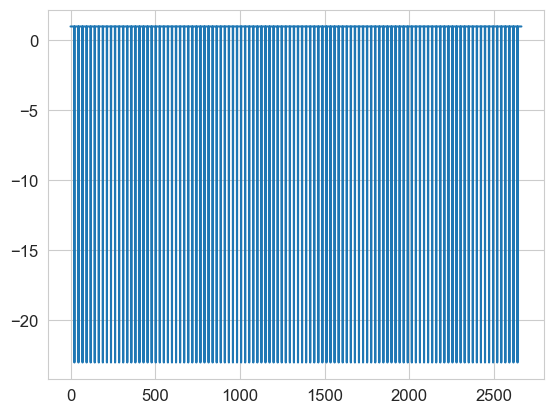

In [139]:
plt.plot(diff_vals);

## Initial EDA

Plot the electricity demand, the rolling average and the rolling standard deviations to see what the demand looks like

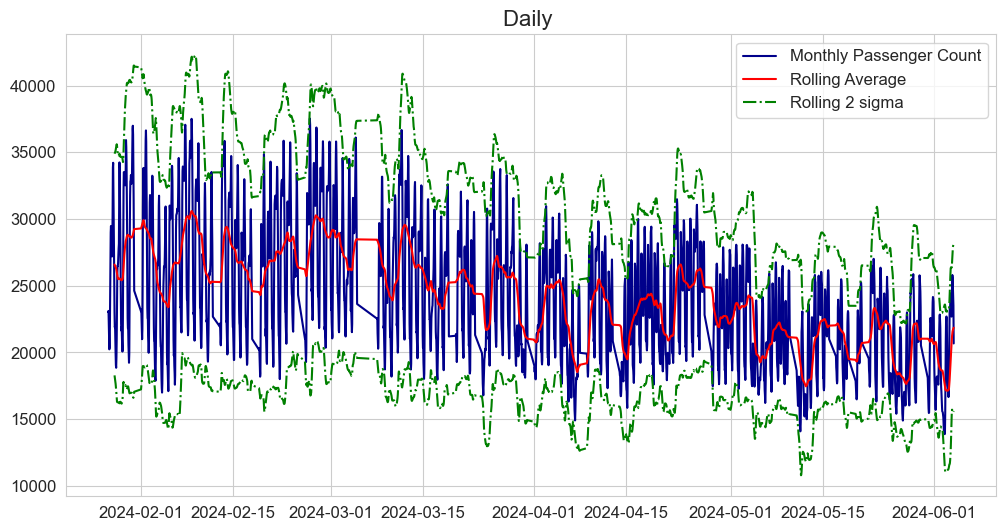

In [104]:
rolling_average = df["england_wales_demand"].rolling(24, center=False).mean()
rolling_std = df["england_wales_demand"].rolling(24, center=False).std()
plt.figure(figsize=(12,6))
plt.plot(df["england_wales_demand"], color='darkblue', label='Monthly Passenger Count')
plt.plot(rolling_average, color='red', label='Rolling Average')
plt.plot(rolling_average + (2 * rolling_std), color='green', linestyle='-.', label='Rolling 2 sigma')
plt.plot(rolling_average - (2 * rolling_std), color='green', linestyle='-.')
plt.legend(loc='best')
plt.title('Daily ')
plt.show(block=False)

It can be observed that there's declining trend as we approach summer time. This is in line with the observations from 2009 to 2023 in [the Kaggle notebook](https://www.nationalgrideso.com/data-portal/historic-demand-data/historic_demand_data_2023). This will make it more challenging to predict the electricity demand and it will lead to frequent model re-training.

Now, let's plot the trend, seasonality, residuals and auto-correlation plots.

In [105]:
def stationarity_tests(
        time_df, series_col, time_series_name, period, lags=12, 
        style='default', plot_size=(16, 32)
    ):
    log_col_name = 'Log {}'.format(series_col) 
    diff_log_col_name = 'LogDiff {}'.format(series_col) 
    time_df[log_col_name] = np.log(time_df[series_col])
    time_df[diff_log_col_name] = time_df[log_col_name].diff()
    decomposed_trend = seasonal_decompose(time_df[series_col], period=period)
    df_index_start = time_df.index.values[0]
    df_index_end = time_df.index.values[len(time_df)-1]
    with plt.style.context(style=style):
        fig, axes = plt.subplots(7, 1, figsize=plot_size)
        plt.subplots_adjust(hspace=0.3)
        axes[0].plot(time_df[series_col], '-', label='Raw data for {}'.format(time_series_name))
        axes[0].legend(loc='upper left')
        axes[0].set_title('Raw data trend for {}'.format(time_series_name)) 
        axes[0].set_ylabel(series_col)
        axes[0].set_xlabel(time_df.index.name)
        axes[1].plot(time_df[diff_log_col_name], 'g-', label='Log Diff for {}'.format(time_series_name))
        axes[1].hlines(0.0, df_index_start, df_index_end, 'r', label='Series center')
        axes[1].legend(loc='lower left')
        axes[1].set_title('Diff Log Trend for outliers in {}'.format(time_series_name))
        axes[1].set_ylabel(series_col)
        axes[1].set_xlabel(time_df.index.name) 
        # the auto-correlation factor and the partial auto-correlation factors can help set hyperparameters
        # for many of the models we'll be testing out in the next chapter.
        fig = plot_acf(time_df[series_col], lags=lags, ax=axes[2])
        fig = plot_pacf(time_df[series_col], lags=lags, ax=axes[3])
        axes[2].set_xlabel('lags')
        axes[2].set_ylabel('correlation')
        axes[3].set_xlabel('lags')
        axes[3].set_ylabel('correlation')
        axes[4].plot(decomposed_trend.trend, 'r-', label='Trend data for {}'.format(time_series_name))
        axes[4].legend(loc='upper left')
        axes[4].set_title('Trend component of decomposition for {}'.format(time_series_name))
        axes[4].set_ylabel(series_col)
        axes[4].set_xlabel(time_df.index.name)
        axes[5].plot(decomposed_trend.seasonal, 'r-', label='Seasonal data for {}'.format(time_series_name))
        axes[5].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[5].set_title('Seasonal component of decomposition for {}'.format(time_series_name))
        axes[5].set_ylabel(series_col)
        axes[5].set_xlabel(time_df.index.name)
        axes[6].plot(decomposed_trend.resid, 'r.', label='Residuals data for {}'.format(time_series_name))
        axes[6].hlines(0.0, df_index_start, df_index_end, 'black', label='Series Center')
        axes[6].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[6].set_title('Residuals component of decomposition for {}'.format(time_series_name))
        axes[6].set_ylabel(series_col)
        axes[6].set_xlabel(time_df.index.name)
    return fig

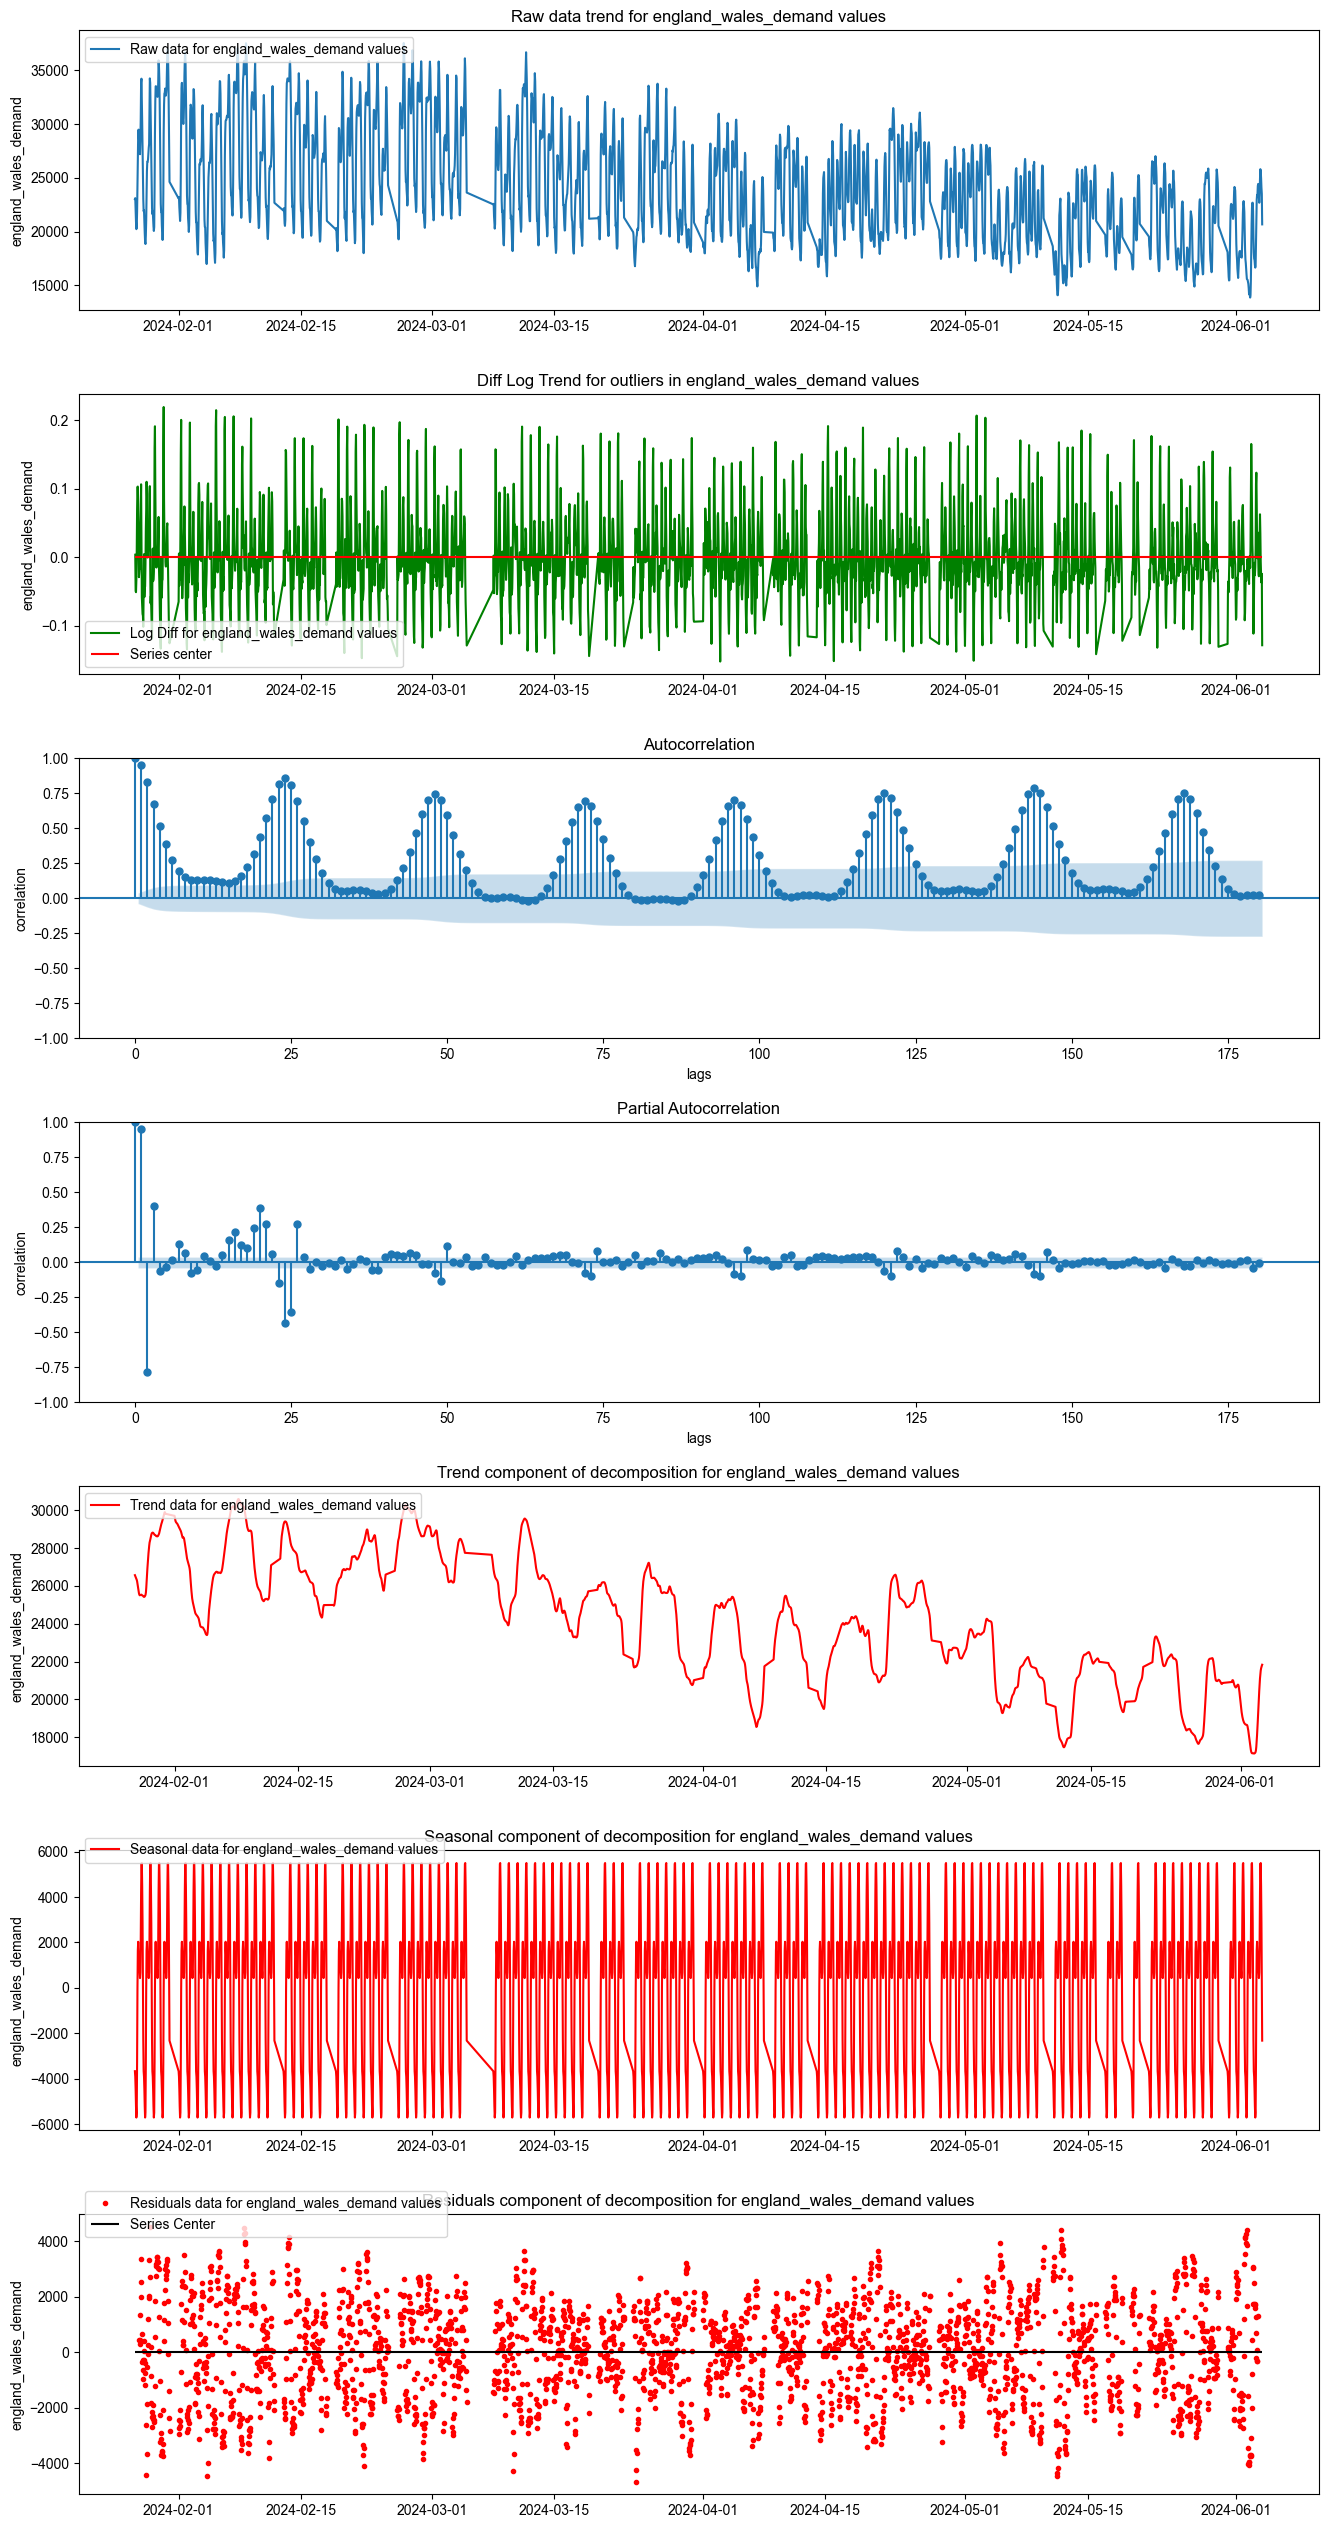

In [106]:
df_copy = df.copy()
stationarity_tests(
    time_df=df_copy,
    series_col="england_wales_demand",
    time_series_name="england_wales_demand values",
    period=24,
    lags=180,
);

## Add new features

Since the ultimate goal of the project is to predict future electricity demand, new features need to be added to the dataset to provide the model with predictive ability. Those features are related to the date, such as hour of the day and day of the week.

In [107]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time series features based on time series index

    Args:
        * df (pd.DataFrame): time series dataframe

    Returns:
        * df (pd.DataFrame): time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

In [108]:
df = create_features(df)
df.head()

settlement_period  england_wales_demand  is_holiday  \
2024-01-27 00:00:00                  1                 23026           0   
2024-01-27 01:00:00                  2                 23114           0   
2024-01-27 02:00:00                  3                 22005           0   
2024-01-27 03:00:00                  4                 20913           0   
2024-01-27 04:00:00                  5                 20232           0   

                     temperature  weather  day_of_month  day_of_week  \
2024-01-27 00:00:00     3.267150        0            27            5   
2024-01-27 01:00:00     2.860870        0            27            5   
2024-01-27 02:00:00     2.545894        0            27            5   
2024-01-27 03:00:00     2.584058        0            27            5   
2024-01-27 04:00:00     2.760386        7            27            5   

                     day_of_year  quarter  month  year  week_of_year  
2024-01-27 00:00:00           27        1      1  2024             4  
2024-01-27 01:00:00           27        1      1  2024             4  
2024-01-27 02:00:00           27        1      1  2024             4  
2024-01-27 03:00:00           27        1      1  2024             4  
2024-01-27 04:00:00           27        1      1  2024             4

### Explore data trends with new features

/var/folders/lr/2bzlrtk94d3_m55p847wcdnc0000gn/T/ipykernel_96653/725319312.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)


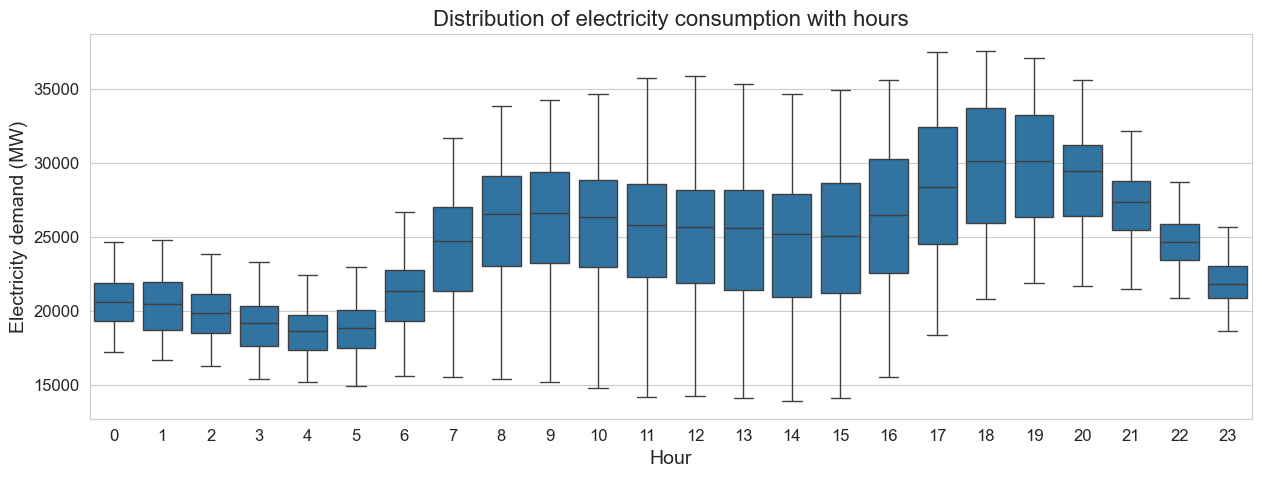

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))
x_ticklabels = df["settlement_period"].unique()-1
sns.boxplot(x="settlement_period", y="england_wales_demand", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

/var/folders/lr/2bzlrtk94d3_m55p847wcdnc0000gn/T/ipykernel_96653/470824989.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)


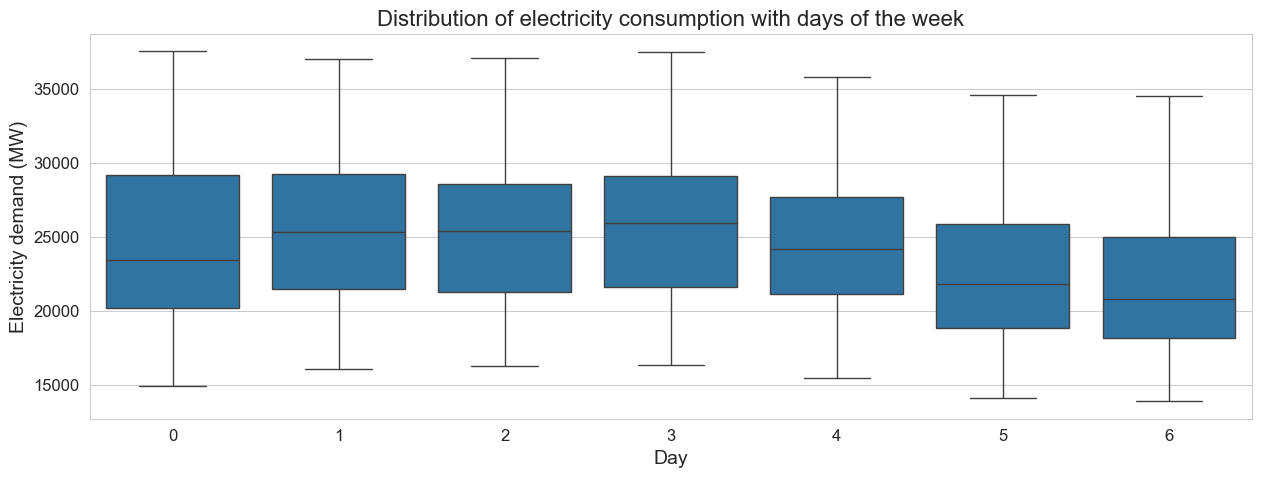

In [110]:
fig, ax = plt.subplots(figsize=(15, 5))
x_ticklabels = sorted(df["day_of_week"].unique())
sns.boxplot(x="day_of_week", y="england_wales_demand", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel("Day")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with days of the week");

As can be seen, the daily consumption isn't constant throughout the week, with lower consumption during the weekend. This means that the dataset also has weekly seasonality. 

# Model prototyping

In this section, I present three different regressor models (XGBoost, Linear Trees and Linear Boost) for two different scenarios: electricity demand prediction with and without weather data

## Model Prototyping - Weather and temperature

Create functions that will be reused throughout the notebook:

In [111]:
def mape(y_true, y_pred) -> float:
    """
    Calculate Mean Absolute Percentage Error

    Args:
        * y_true: ground truth values
        * y_pred: predictions

    Returns:
        float: mape value
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_errors(y_true, y_pred) -> dict:
    """
    Calculate key metrics to assess model performance

    Args:
        * y_true: ground truth values
        * y_pred: predictions

    Returns:
        * dict: dictionary containing metrics
    """
    # create a dictionary to store all of the metrics
    error_scores = {}
    
    mse = mean_squared_error(y_true, y_pred)
    
    error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    error_scores['mape'] = mape(y_true, y_pred)
    error_scores['mse'] = mse
    error_scores['rmse'] = np.sqrt(mse)
    error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    error_scores['r2'] = r2_score(y_true, y_pred)
    return error_scores

def plot_predictions(
        y_true, y_pred, time_series_name, value_name, model_name, plot_size=(16, 12)
    ):
    """
    Function for a standardized forecasting visualization that can be used
    for all experiments being conducted

    Args:
        * y_true: the ground-truth values during the forecasting period that we'll be using for 
            validation (holdout data)
        * y_pred: the forecast values during the holdout period
        * time_series_name: a name for the plot
        * value_name: the name for our y-axis on the plot
        * image_name: the name of the file to save the visualization as in svg format
        * style: (default 'seaborn') the visual style of the plots
        * plot_size: (default 16 x 12 inches) the size of the figure we're going to generate
    """
    # dictionary for currying
    validation_output = {} 
    
    # full error metrics suite as shown in listing 6.6
    error_values = calculate_errors(y_true, y_pred)
    
    # store all of the raw values of the errors
    validation_output['errors'] = error_values
    
    # create a string to populate a bounding box with on the graph
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    )) 

    fig, axes = plt.subplots(1, 1, figsize=plot_size)
    axes.plot(y_true, 'b-', label='Test data for {}'.format(time_series_name))
    axes.plot(y_pred, 'r-', label='Forecast data for {}'.format(time_series_name))
    axes.legend(loc='upper left')
    axes.set_title('Raw and Predicted data trend for {} using {}'.format(time_series_name, model_name))
    axes.set_ylabel(value_name)
    axes.set_xlabel(y_true.index.name)
    
    # create an overlay bounding box so that all of our metrics are displayed on the plot
    props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
    axes.text(0.9, 0.9, text_str, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=props)
    validation_output['plot'] = fig
    # plt.savefig(image_name, format='svg')
    plt.tight_layout()

    return validation_output

def split_data(
        threshold_date_1: str,
        df: pd.DataFrame,
        visualise_split: bool,
        threshold_date_2: str = None
) -> Tuple[pd.DataFrame, pd.DataFrame, Union[pd.DataFrame, List]]:
    """
    Split data into training, test and hold out sets given the threshold
    dates

    Args:
        * threshold_date_1 (str): threshold date 1, used for train-test splot
        * df (pd.DataFrame): data frame
        * threshold_date_2 (str, optional): threshold date 2, used for test-hold-out split
            Defaults to None

    Returns:
        * pd.DataFrame: data frame containing training data
        * pd.DataFrame: data frame containing test data
        * Union[pd.DataFrame, List]: data frame containing hold-out data
            if threshold_date_2 is provided, otherwise an empty list
    """

    nearest_date_1 = df[:threshold_date_1].iloc(0)[-1].name
    train_data = df.loc[df.index < nearest_date_1]
    # Add test and hold-out sets if threshold_2 is available, otherwise, generate testset only
    if threshold_date_2:
        nearest_date_2 = df[:threshold_date_2].iloc(0)[-1].name
        test_data = df.loc[(df.index >= nearest_date_1) & (df.index < nearest_date_2)]
        hold_out_data = df.loc[df.index >= nearest_date_2]
    else:
        test_data = df.loc[df.index >= nearest_date_1]
        hold_out_data = []

    if visualise_split:
        fig, ax = plt.subplots(figsize=(15, 5))
        train_data["england_wales_demand"].plot(ax=ax, label="Training set")
        test_data["england_wales_demand"].plot(ax=ax, label="Test set")
        ax.axvline(threshold_date_1, color="k", ls="--")
        if threshold_date_2:
            hold_out_data["england_wales_demand"].plot(ax=ax, label="Hold-out set")
            ax.axvline(threshold_date_2, color="k", ls=":")
        ax.set_title("Training-test split")
        plt.legend();

    return train_data, test_data, hold_out_data



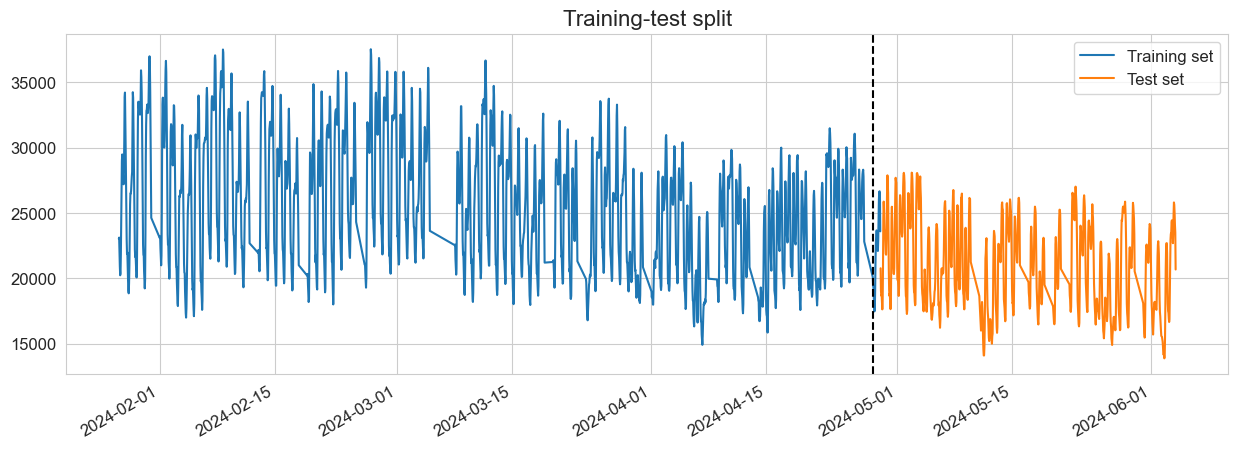

In [112]:
threshold_date_1 = "2024-04-28"
threshold_date_2 = None
train_data, test_data, hold_out_data = split_data(
    threshold_date_1, df, True, threshold_date_2
)

In [113]:
# Define the features and target variable
TARGET = "england_wales_demand"
FEATURES = [column for column in df.columns if column != TARGET]

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

if hold_out_data:
    X_hold_out = hold_out_data[FEATURES]
    y_hold_out = hold_out_data[TARGET]

RAND_STATE = 42

In [114]:
X_train.head()

settlement_period  is_holiday  temperature  weather  \
2024-01-27 00:00:00                  1           0     3.267150        0   
2024-01-27 01:00:00                  2           0     2.860870        0   
2024-01-27 02:00:00                  3           0     2.545894        0   
2024-01-27 03:00:00                  4           0     2.584058        0   
2024-01-27 04:00:00                  5           0     2.760386        7   

                     day_of_month  day_of_week  day_of_year  quarter  month  \
2024-01-27 00:00:00            27            5           27        1      1   
2024-01-27 01:00:00            27            5           27        1      1   
2024-01-27 02:00:00            27            5           27        1      1   
2024-01-27 03:00:00            27            5           27        1      1   
2024-01-27 04:00:00            27            5           27        1      1   

                     year  week_of_year  
2024-01-27 00:00:00  2024             4  
2024-01-27 01:00:00  2024             4  
2024-01-27 02:00:00  2024             4  
2024-01-27 03:00:00  2024             4  
2024-01-27 04:00:00  2024             4

### XGBoost

In [115]:
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=RAND_STATE
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train)],
    verbose=100,
);

[0]	validation_0-rmse:4855.47773
[100]	validation_0-rmse:2875.37933
[200]	validation_0-rmse:1946.65951
[300]	validation_0-rmse:1561.95788
[400]	validation_0-rmse:1355.34037
[499]	validation_0-rmse:1229.06618


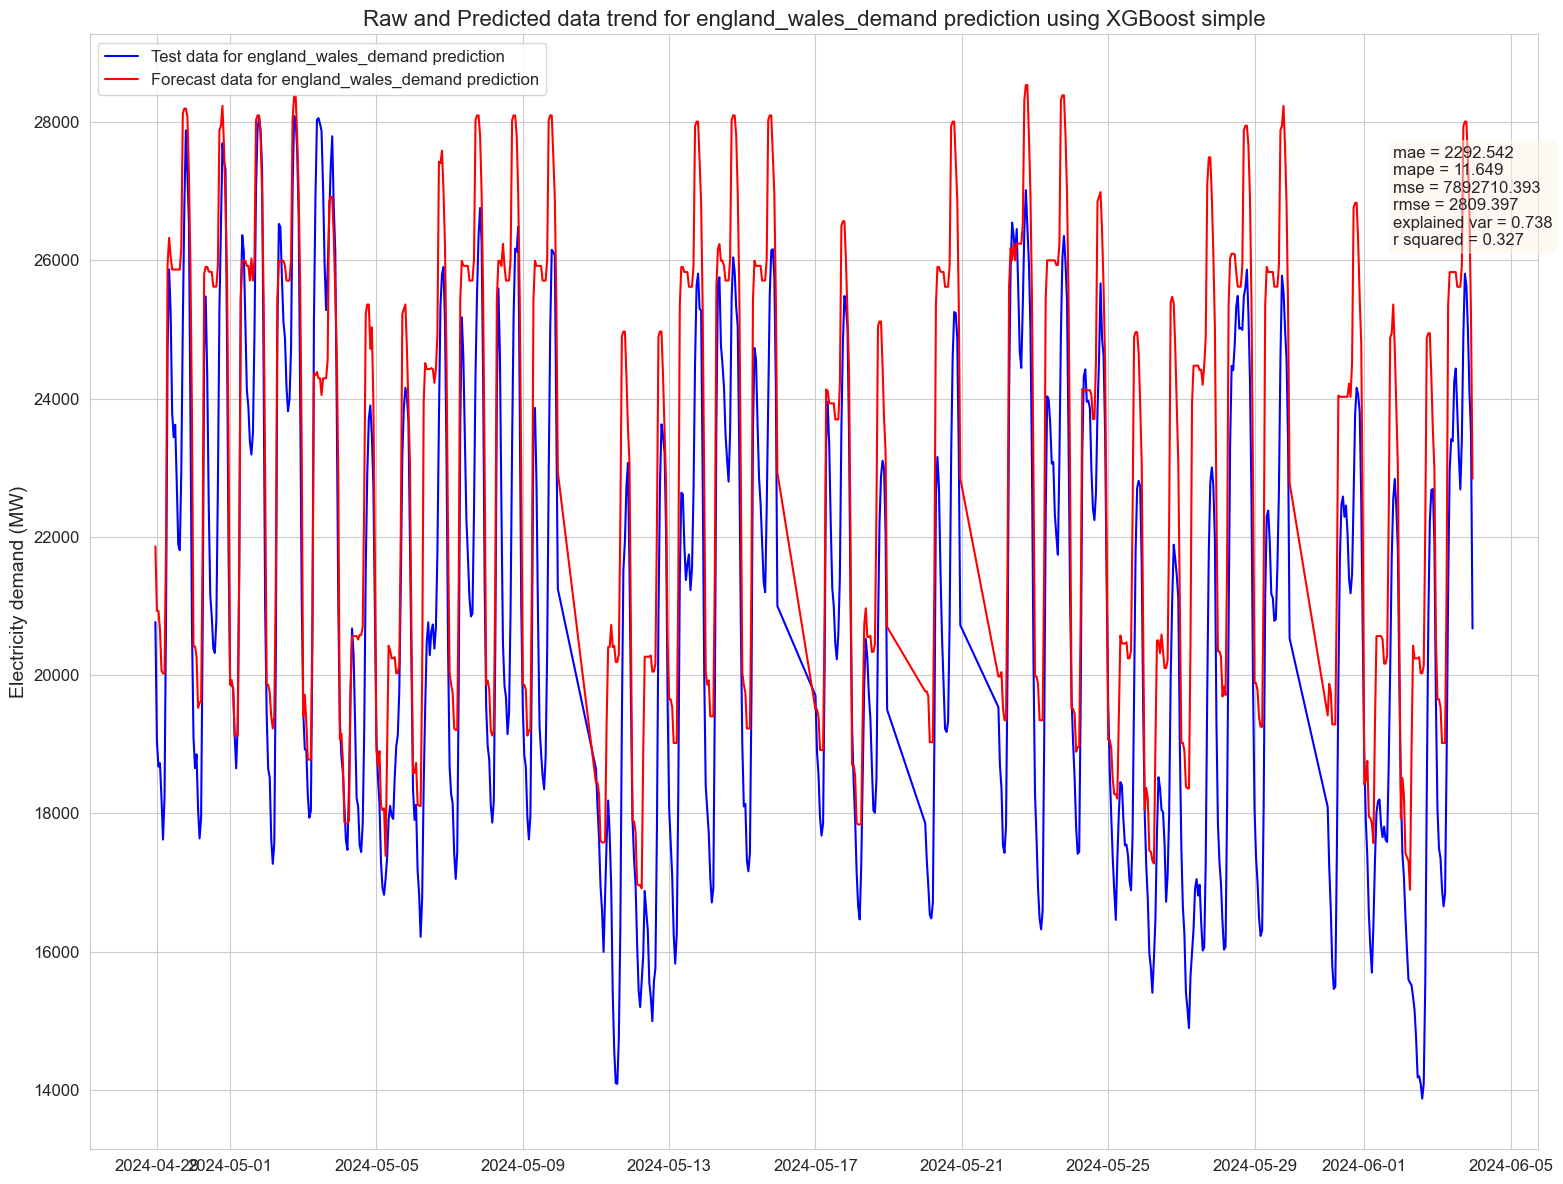

In [116]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

xgb_simple_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_xgb_simple"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "XGBoost simple"
);

In [117]:
xgb_advanced = xgb.XGBRegressor(
    n_estimators=700,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.7,
    booster="gbtree",
    early_stopping_rounds=50,
    random_state=RAND_STATE
)

xgb_advanced.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train)],
    verbose=100,
)

[0]	validation_0-rmse:4848.53415
[100]	validation_0-rmse:2330.01834
[200]	validation_0-rmse:1422.80221
[300]	validation_0-rmse:1031.73574
[400]	validation_0-rmse:832.78457
[500]	validation_0-rmse:718.96990
[600]	validation_0-rmse:644.15114
[699]	validation_0-rmse:588.76218


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

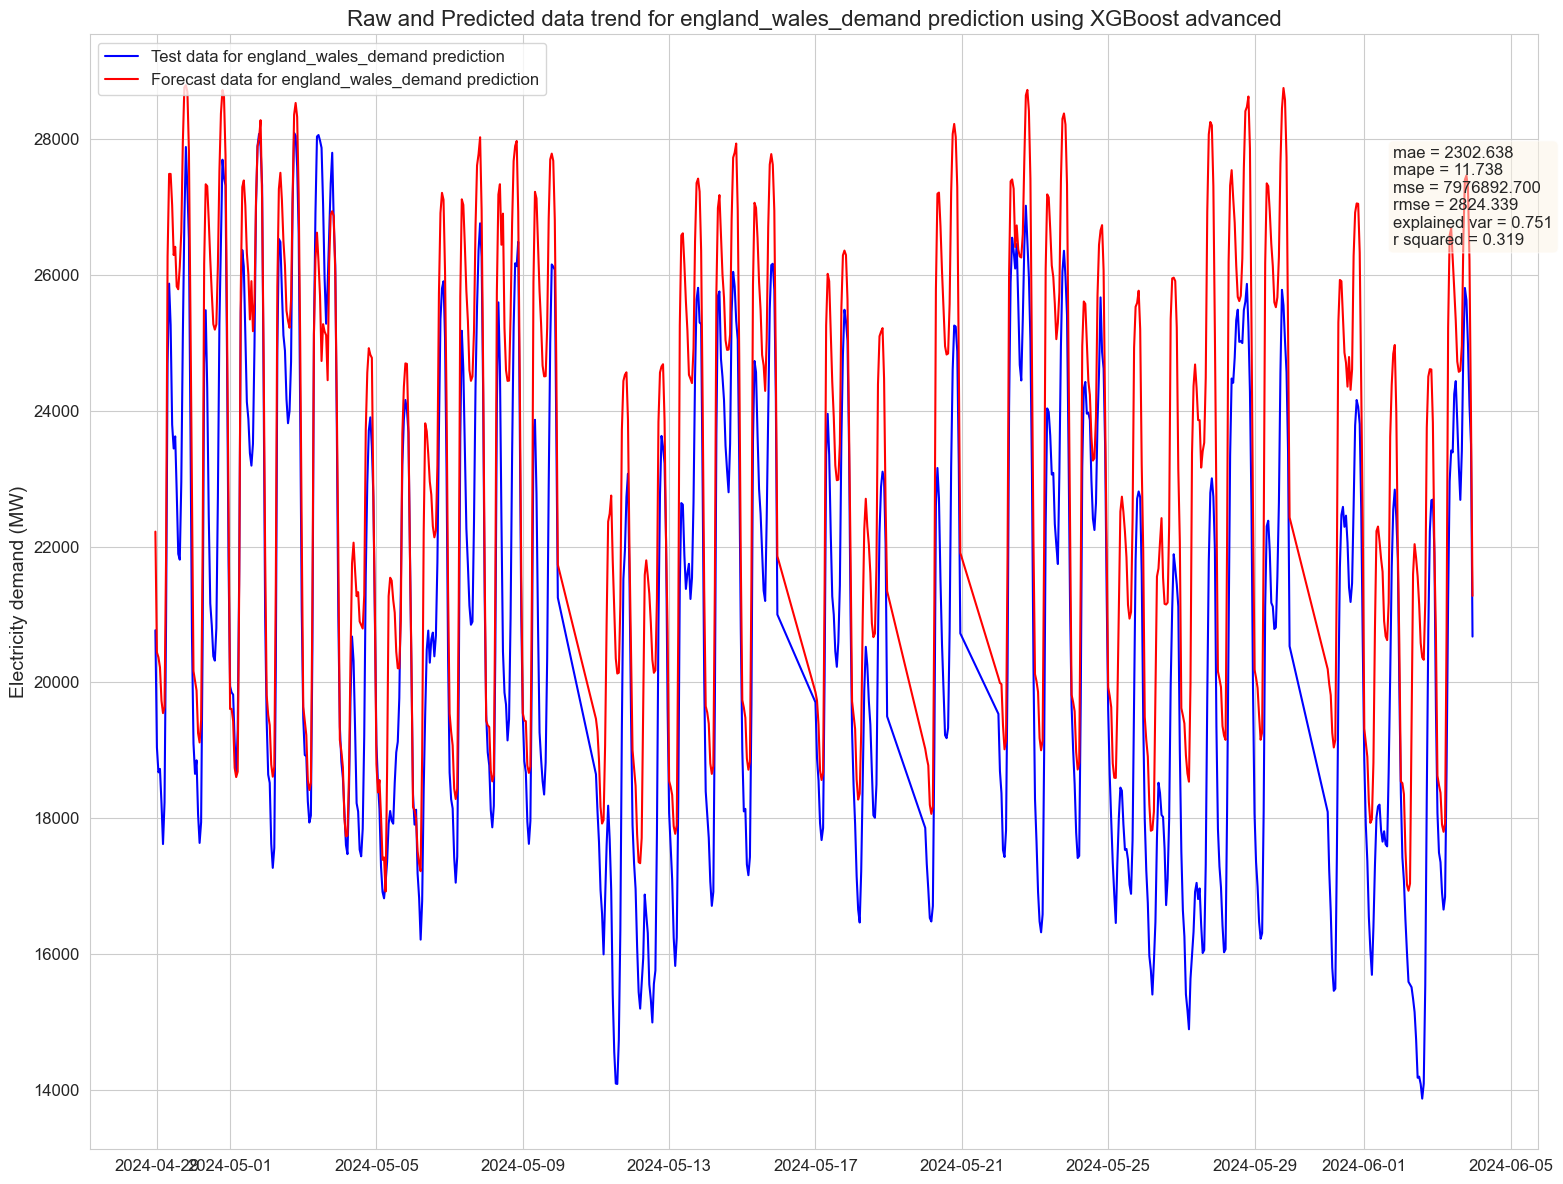

In [118]:
result_frame["pred_xgb_advanced"] = xgb_advanced.predict(X_test)

xgb_advanced_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_xgb_advanced"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "XGBoost advanced"
)

### Linear Boost

In [119]:
%%time
linear_boost_simple = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 100, 
    max_depth = 4,
    random_state = RAND_STATE,
)

linear_boost_simple.fit(X_train, y_train)

CPU times: user 2min 33s, sys: 55.7 s, total: 3min 28s
Wall time: 22.3 s


LinearBoostRegressor(base_estimator=LinearRegression(n_jobs=-1), max_depth=4,
                     n_estimators=100, random_state=42)

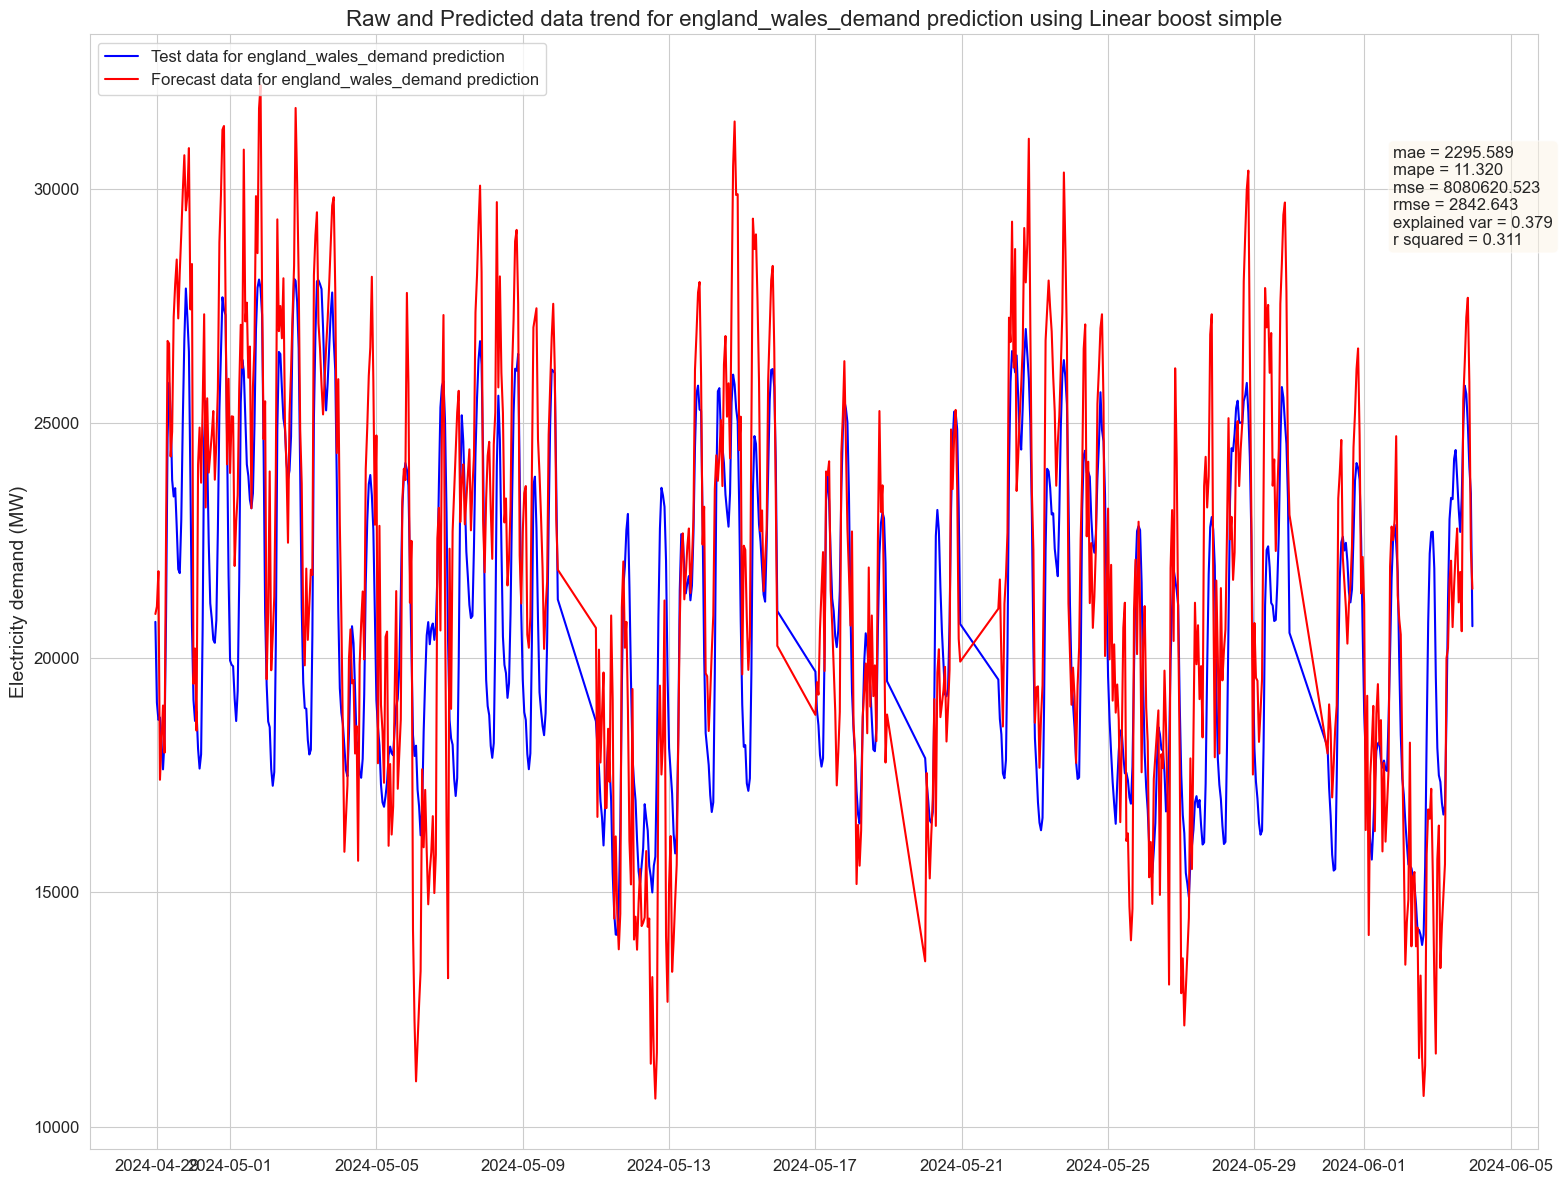

In [120]:
result_frame["pred_linear_boost_simple"] = linear_boost_simple.predict(X_test)

linear_boost_simple_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_linear_boost_simple"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "Linear boost simple"
)

In [121]:
%%time
linear_boost_advanced = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 250, 
    max_depth = 5,
    random_state = RAND_STATE,
)

linear_boost_advanced.fit(X_train, y_train)

CPU times: user 7min 8s, sys: 3min 18s, total: 10min 27s
Wall time: 1min 7s


LinearBoostRegressor(base_estimator=LinearRegression(n_jobs=-1), max_depth=5,
                     n_estimators=250, random_state=42)

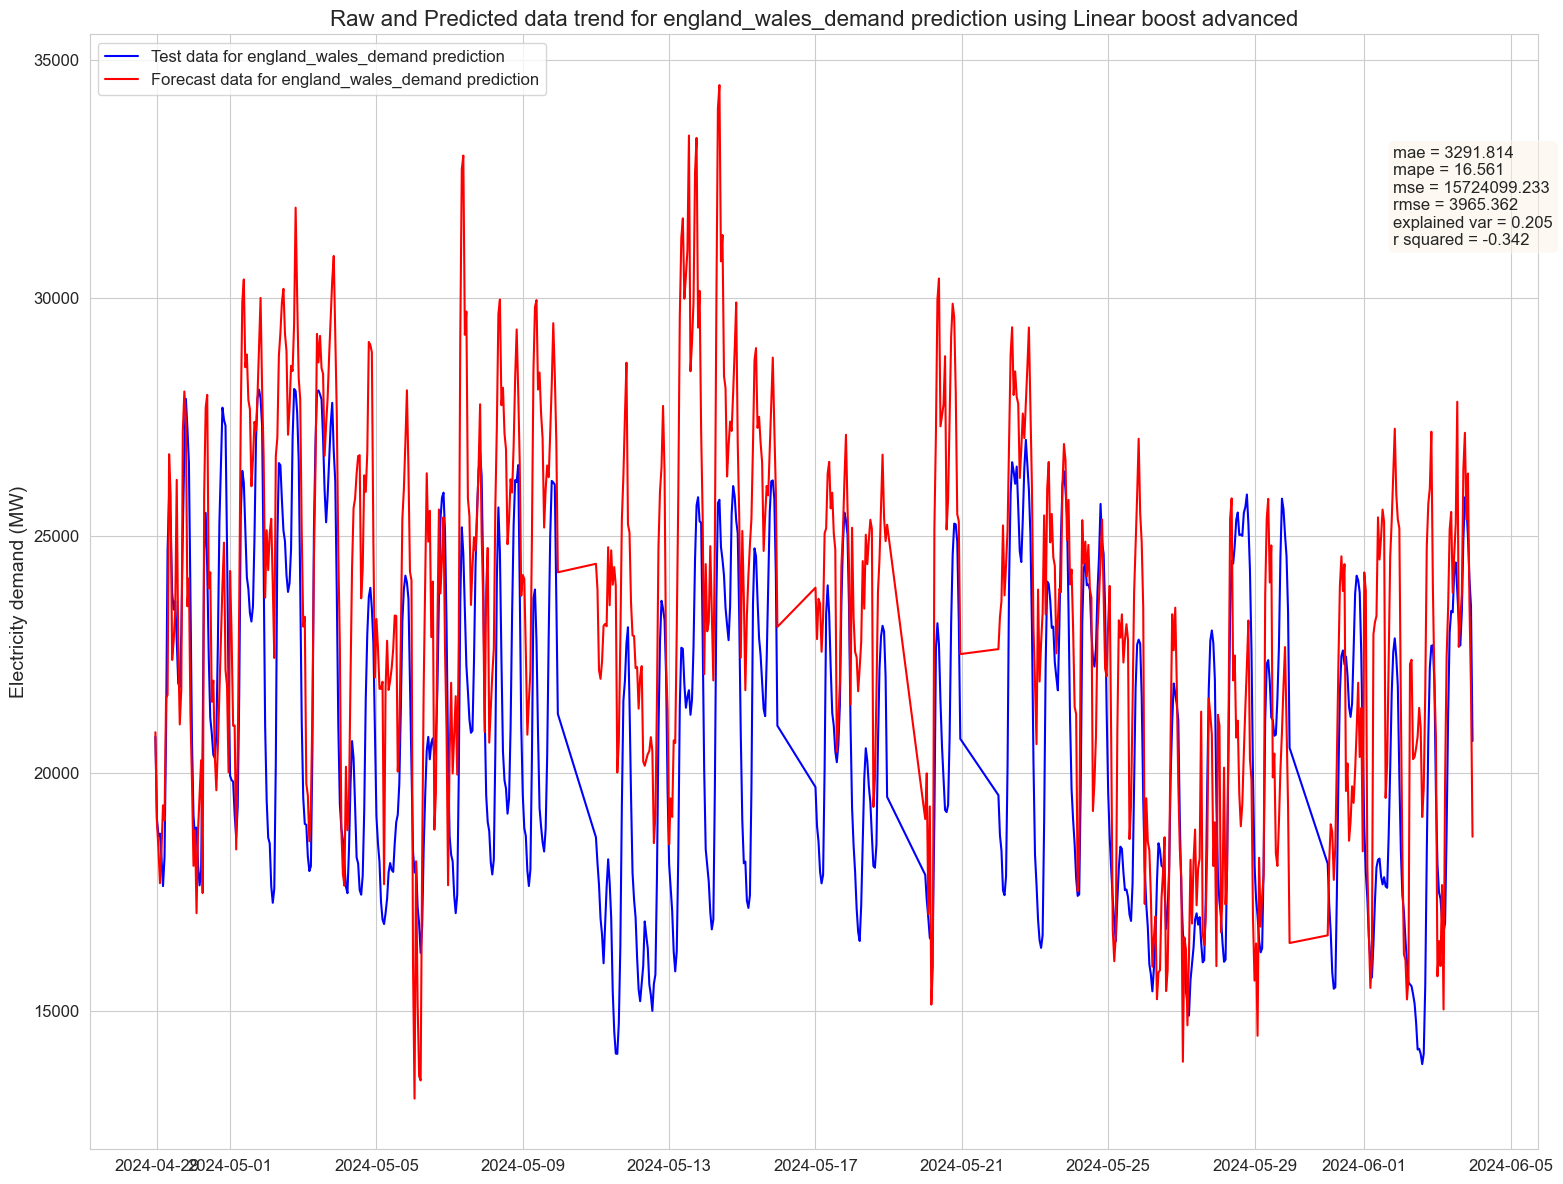

In [122]:
result_frame["pred_linear_boost_advanced"] = linear_boost_advanced.predict(X_test)

linear_boost_advanced_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_linear_boost_advanced"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "Linear boost advanced"
);

### Linear Trees

In [123]:
%%time
linear_trees_simple = LinearTreeRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    max_depth = 4,
)

linear_trees_simple.fit(X_train, y_train)

CPU times: user 9.82 s, sys: 7.11 s, total: 16.9 s
Wall time: 1.86 s


LinearTreeRegressor(base_estimator=LinearRegression(n_jobs=-1), max_depth=4)

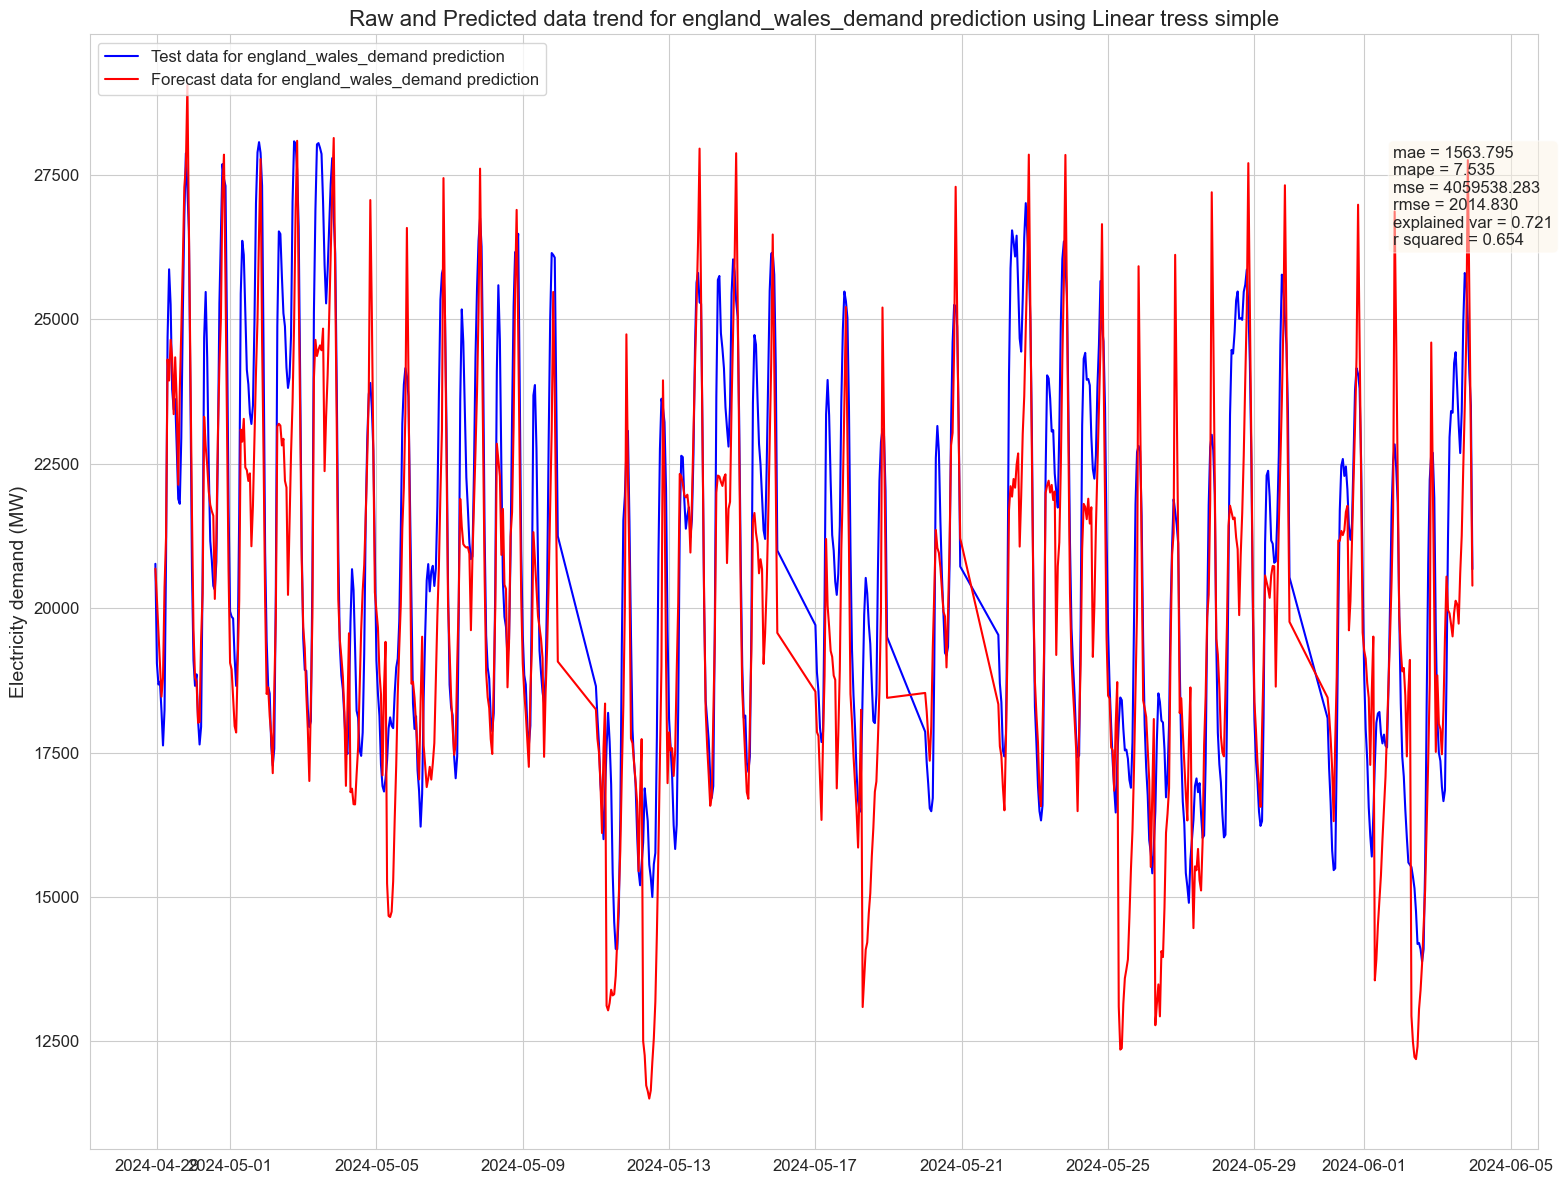

In [124]:
result_frame["pred_linear_trees_simple"] = linear_trees_simple.predict(X_test)

linear_trees_simple_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_linear_trees_simple"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "Linear tress simple"
)

In [125]:
%%time
linear_trees_advanced = LinearTreeRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    max_depth = 6,
)

linear_trees_advanced.fit(X_train, y_train)

CPU times: user 9.7 s, sys: 8.59 s, total: 18.3 s
Wall time: 1.99 s


LinearTreeRegressor(base_estimator=LinearRegression(n_jobs=-1), max_depth=6)

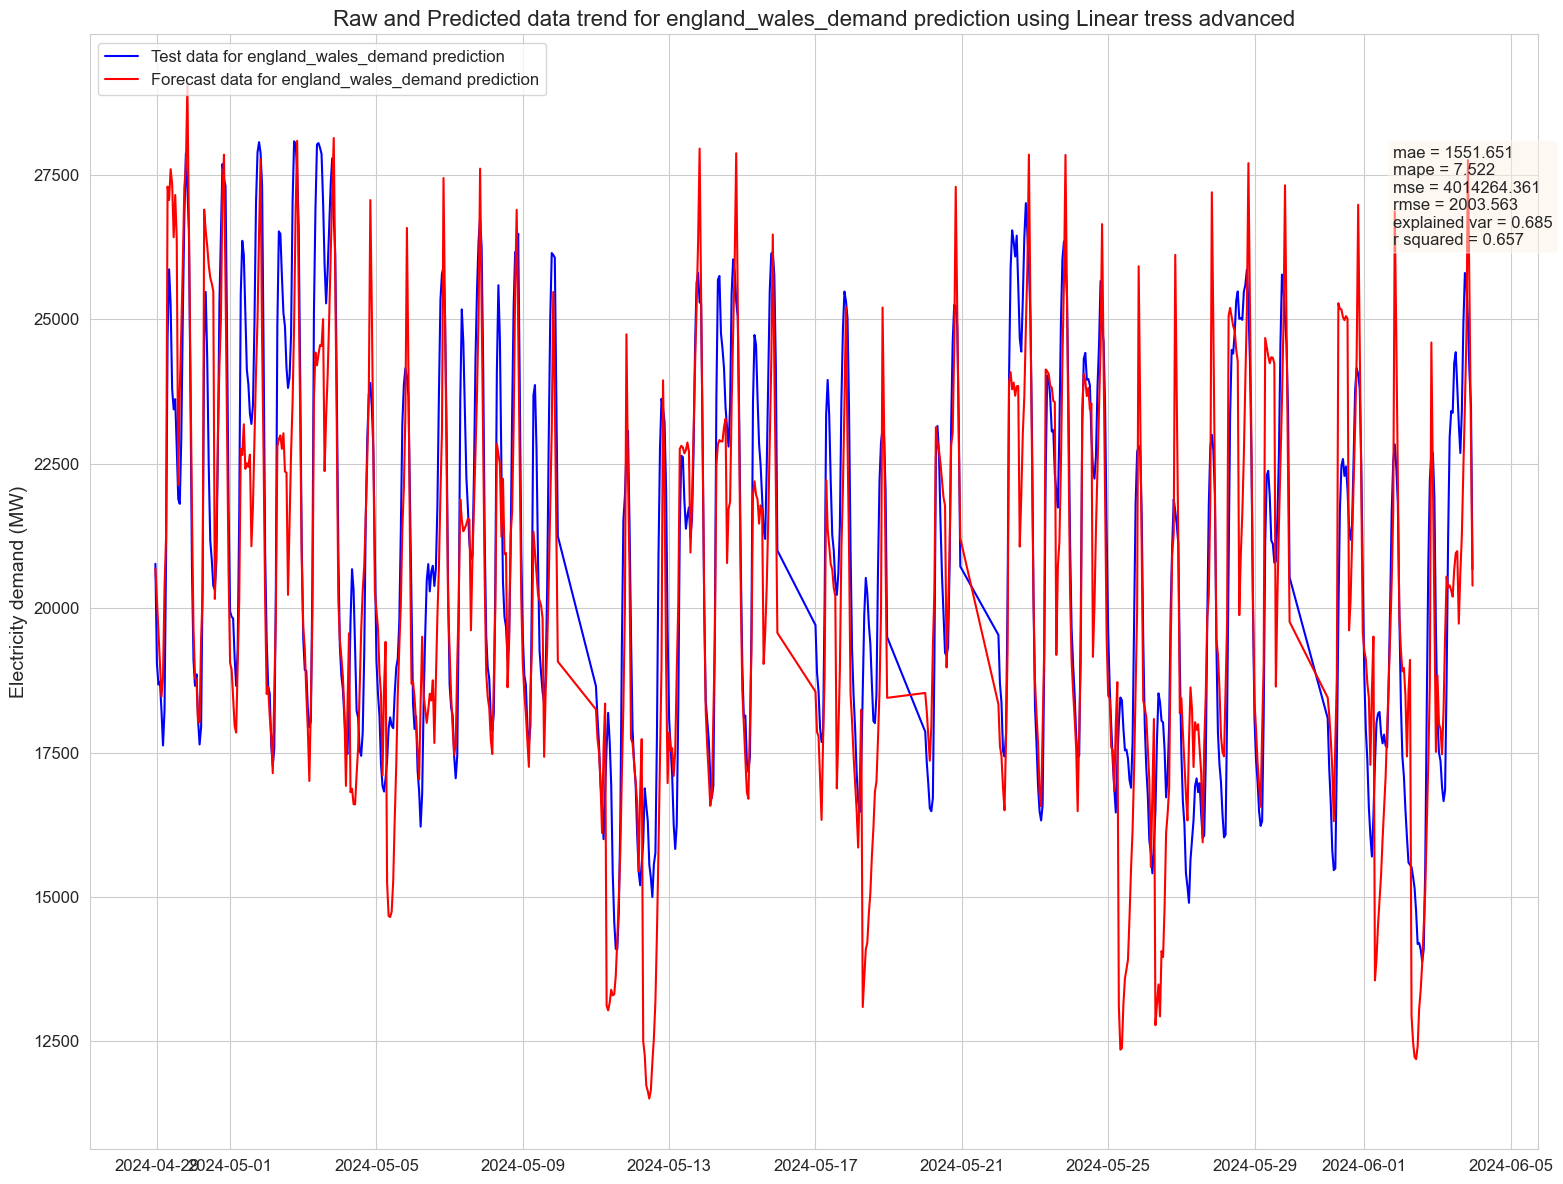

In [126]:
result_frame["pred_linear_trees_advanced"] = linear_trees_advanced.predict(X_test)

linear_trees_advanced_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_linear_trees_advanced"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "Linear tress advanced"
)

## Model prototyping - No weather data

In [127]:
df.columns.to_list()

['settlement_period',
 'england_wales_demand',
 'is_holiday',
 'temperature',
 'weather',
 'day_of_month',
 'day_of_week',
 'day_of_year',
 'quarter',
 'month',
 'year',
 'week_of_year']

In [128]:
# Define the features and target variable
TARGET = "england_wales_demand"
FEATURES = ['settlement_period',
    'is_holiday',
    'day_of_month',
    'day_of_week',
    'day_of_year',
    'quarter',
    'month',
    'year',
    'week_of_year'
]

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

if hold_out_data:
    X_hold_out = hold_out_data[FEATURES]
    y_hold_out = hold_out_data[TARGET]

RAND_STATE = 42

### XGBoost

In [129]:
xgb_simple_no_weather = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=RAND_STATE
)

xgb_simple_no_weather.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train)],
    verbose=100,
);

[0]	validation_0-rmse:4855.56828
[100]	validation_0-rmse:2884.52236
[200]	validation_0-rmse:1976.70311
[300]	validation_0-rmse:1618.21114
[400]	validation_0-rmse:1438.06024
[499]	validation_0-rmse:1333.04240


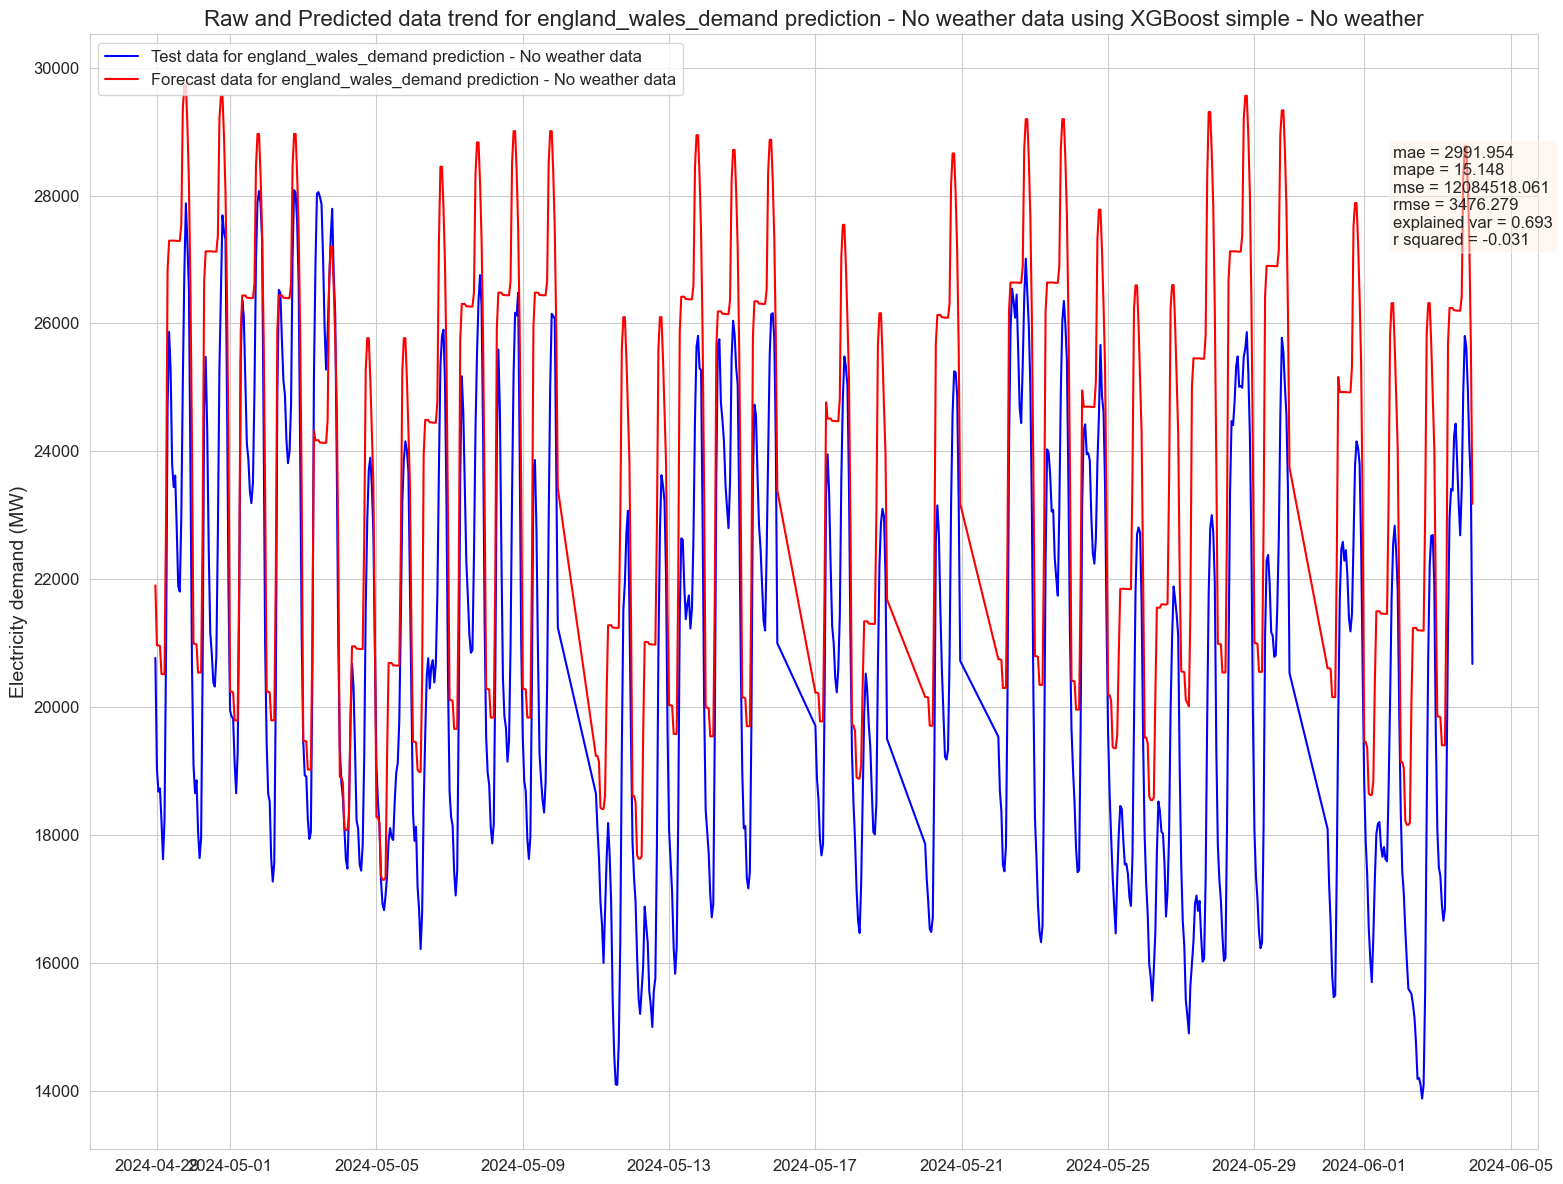

In [130]:
result_frame["pred_xgb_simple_no_weather"] = xgb_simple_no_weather.predict(X_test)

xgb_simple_no_weather_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_xgb_simple_no_weather"],
    "england_wales_demand prediction - No weather data",
    "Electricity demand (MW)",
    "XGBoost simple - No weather"
);

In [131]:
xgb_advanced = xgb.XGBRegressor(
    n_estimators=700,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.7,
    booster="gbtree",
    early_stopping_rounds=50,
    random_state=RAND_STATE
)

xgb_advanced.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train)],
    verbose=100,
);

[0]	validation_0-rmse:4848.68477
[100]	validation_0-rmse:2354.24886
[200]	validation_0-rmse:1489.07563
[300]	validation_0-rmse:1121.80718
[400]	validation_0-rmse:918.47433
[500]	validation_0-rmse:791.77093
[600]	validation_0-rmse:710.28150
[699]	validation_0-rmse:652.75906


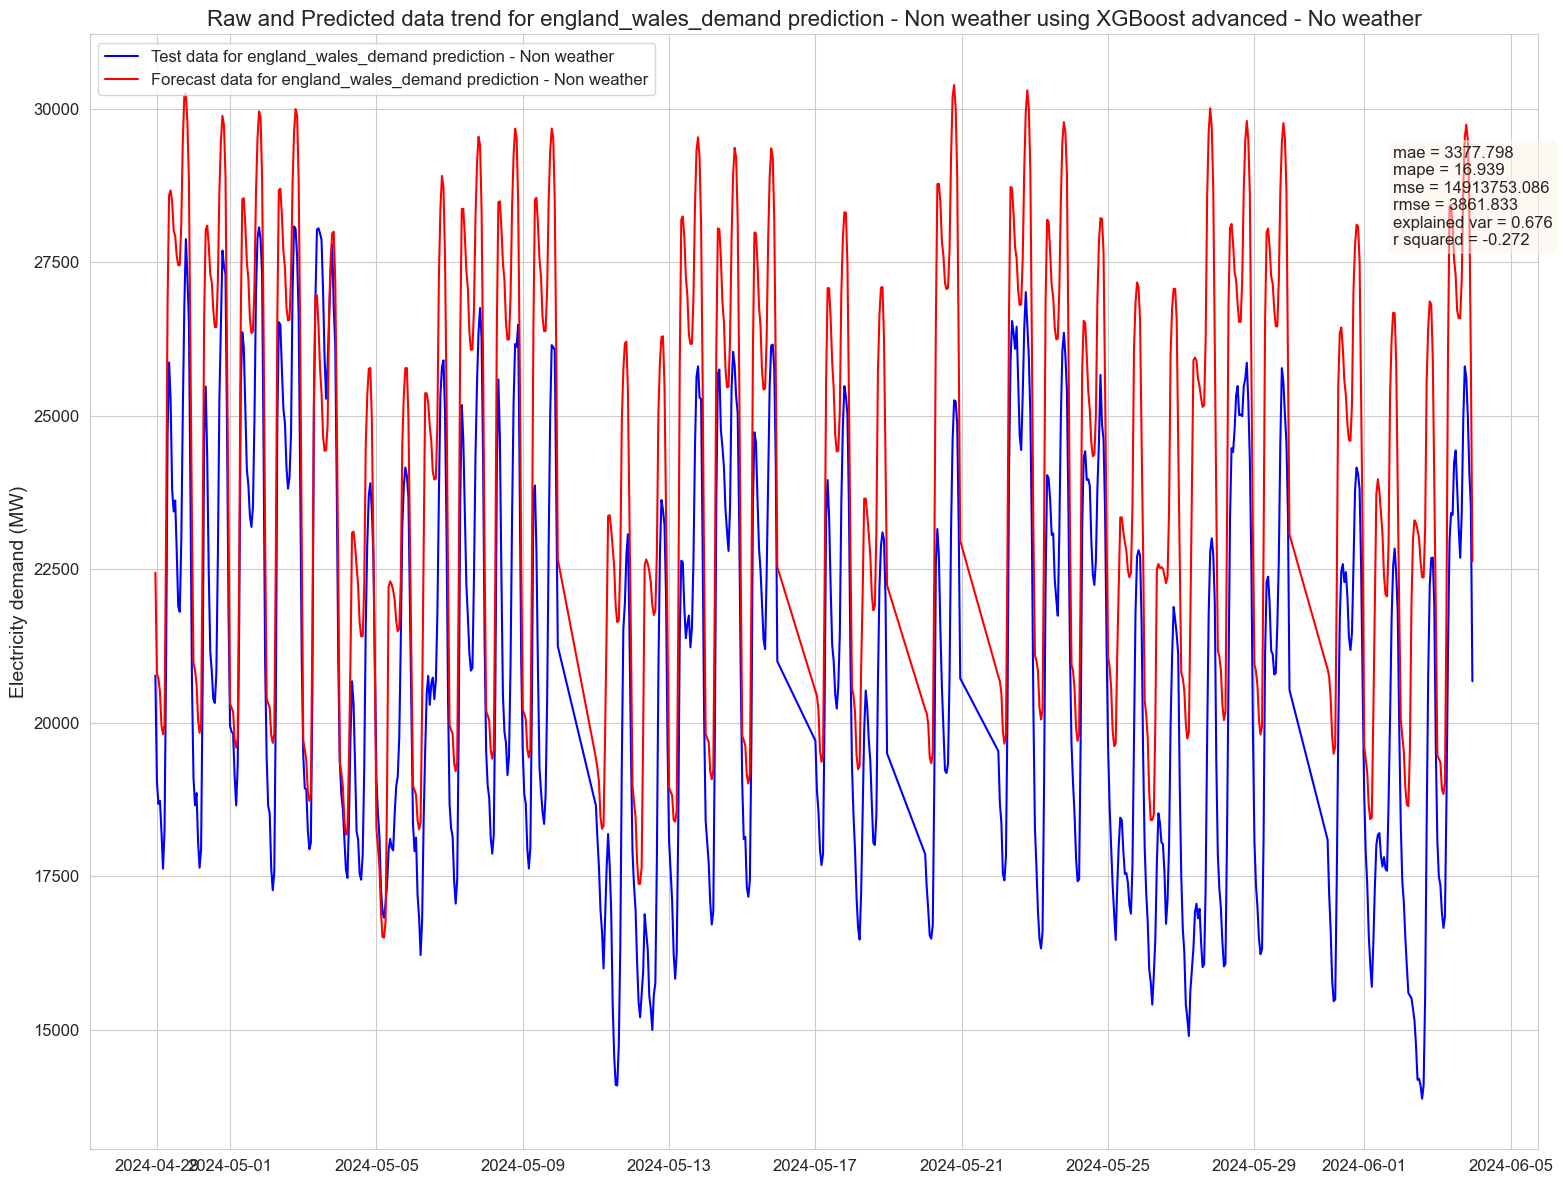

In [132]:
result_frame["pred_xgb_advanced_no_weather"] = xgb_advanced.predict(X_test)

xgb_advanced_no_weather_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_xgb_advanced_no_weather"],
    "england_wales_demand prediction - Non weather",
    "Electricity demand (MW)",
    "XGBoost advanced - No weather"
)

### Linear boosted trees


In [133]:
%%time
linear_boost_simple_no_weather = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 100, 
    max_depth = 4,
    random_state = RAND_STATE,
)

linear_boost_simple_no_weather.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 57.2 s, total: 3min 23s
Wall time: 21.5 s


LinearBoostRegressor(base_estimator=LinearRegression(n_jobs=-1), max_depth=4,
                     n_estimators=100, random_state=42)

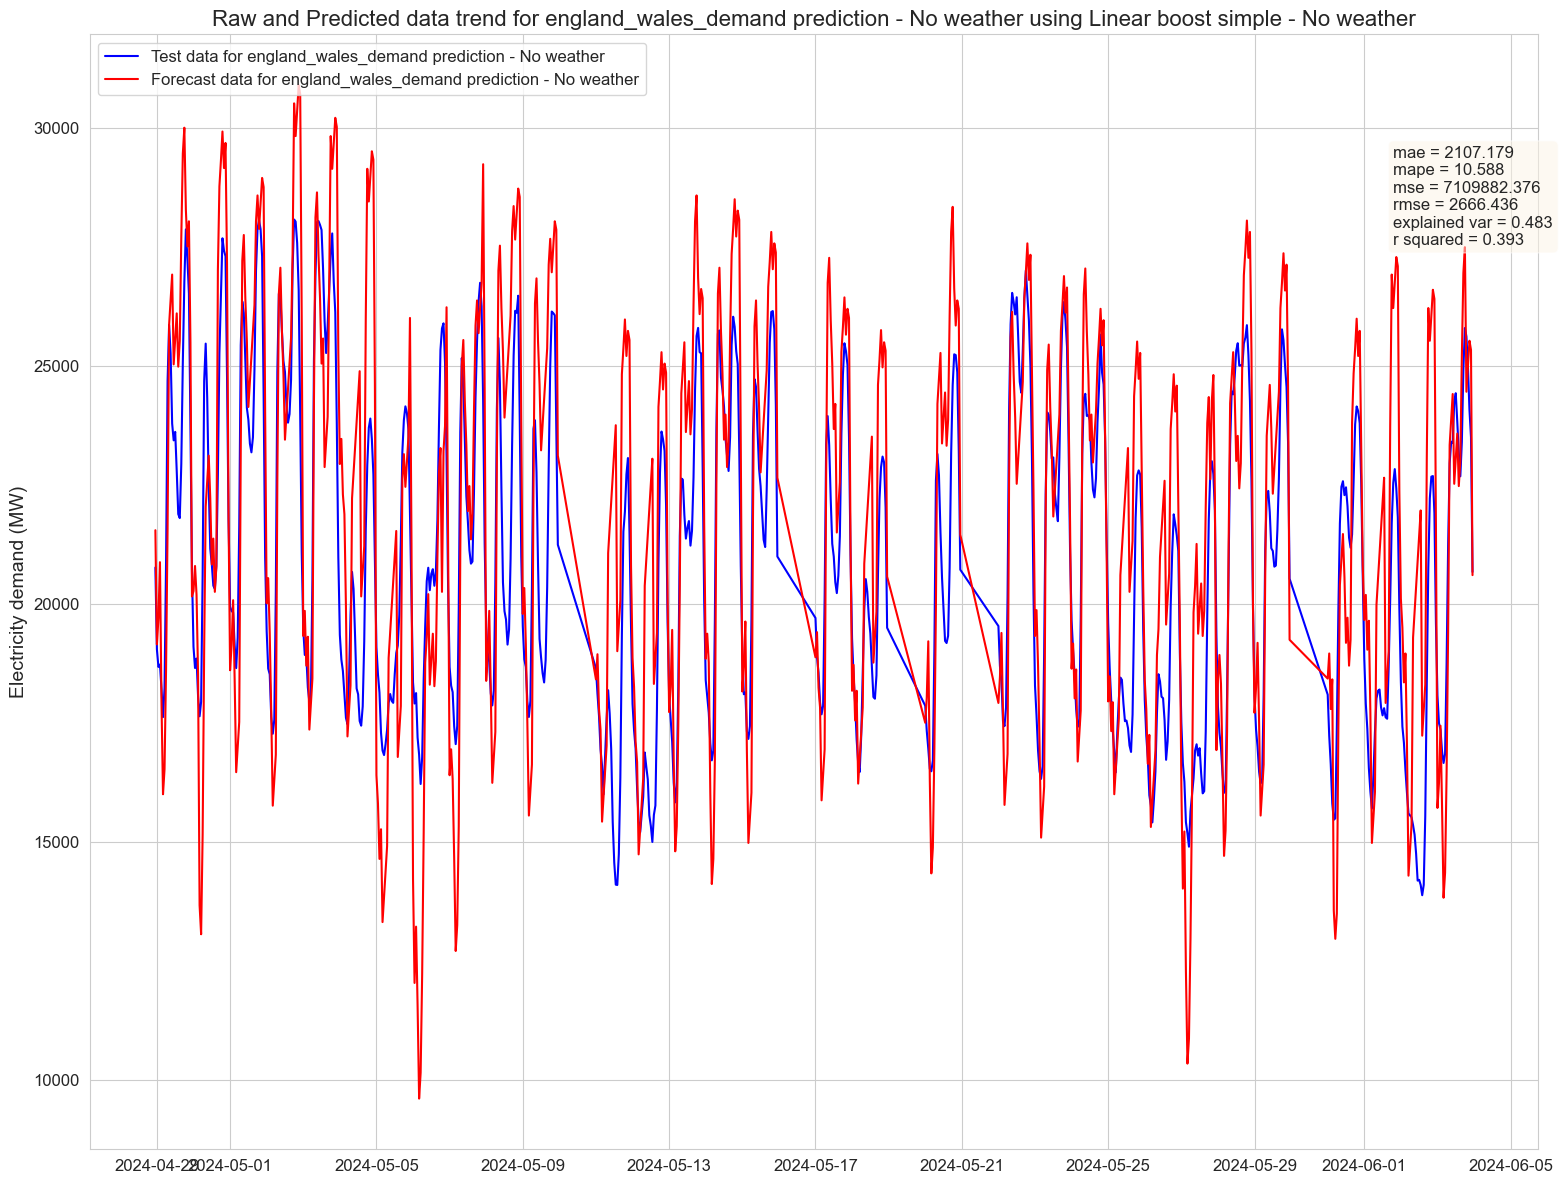

In [134]:
result_frame["pred_linear_boost_simple_no_weather"] = linear_boost_simple_no_weather.predict(X_test)

linear_boost_simple_no_weather_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_linear_boost_simple_no_weather"],
    "england_wales_demand prediction - No weather",
    "Electricity demand (MW)",
    "Linear boost simple - No weather"
)

In [135]:
%%time
linear_boost_advanced_no_weather = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 250, 
    max_depth = 5,
    random_state = RAND_STATE,
)

linear_boost_advanced_no_weather.fit(X_train, y_train)

CPU times: user 6min 45s, sys: 3min 37s, total: 10min 22s
Wall time: 1min 5s


LinearBoostRegressor(base_estimator=LinearRegression(n_jobs=-1), max_depth=5,
                     n_estimators=250, random_state=42)

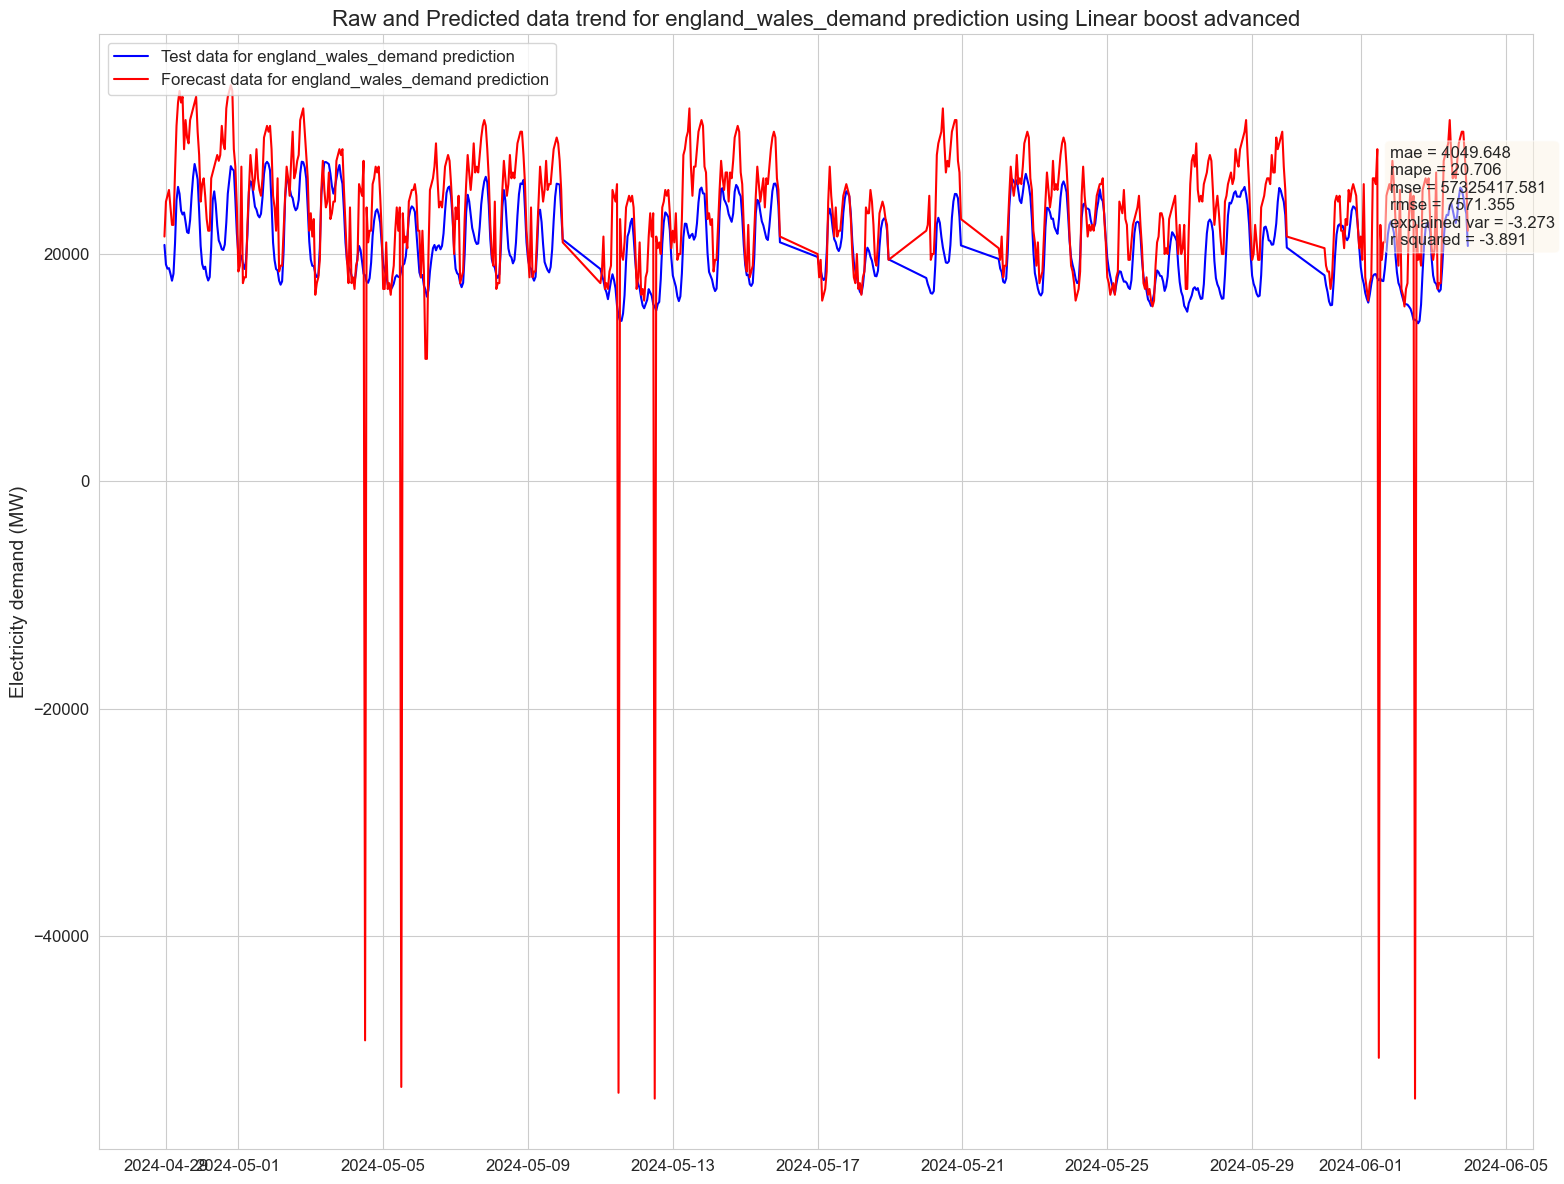

In [136]:
result_frame["pred_linear_boost_advanced_no_weather"] = linear_boost_advanced_no_weather.predict(X_test)

linear_boost_advanced_no_weather_metrics = plot_predictions(
    result_frame["england_wales_demand"],
    result_frame["pred_linear_boost_advanced_no_weather"],
    "england_wales_demand prediction",
    "Electricity demand (MW)",
    "Linear boost advanced"
);

## Weather vs No Weather data comparison

In [137]:
xgb_simple_metrics["errors"]

{'mae': 2292.5418309563756,
 'mape': 11.648997485056208,
 'mse': 7892710.39329537,
 'rmse': 2809.3968023928855,
 'explained_var': 0.7383899583918399,
 'r2': 0.32656532526016235}

In [138]:
metrics_df = pd.DataFrame(data=[
        xgb_simple_metrics["errors"],
        xgb_advanced_metrics["errors"],
        linear_boost_simple_metrics["errors"],
        linear_boost_advanced_metrics["errors"],
        linear_trees_simple_metrics["errors"],
        linear_trees_advanced_metrics["errors"],
        xgb_simple_no_weather_metrics["errors"],
        xgb_advanced_no_weather_metrics["errors"],
        linear_boost_simple_no_weather_metrics["errors"],
        linear_boost_advanced_no_weather_metrics["errors"]
    ]
)

metrics_df.rename(index={
    0: "xgb_simple",
    1: "xgb_advanced",
    2: "linear_boost_simple",
    3: "linear_boost_advanced",
    4: "linear_trees_simple",
    5: "linear_trees_advanced",
    6: "xgb_simple - no weather",
    7: "xgb_advanced - no weather",
    8: "linear_boost_simple - no weather",
    9: "linear_boost_advanced - no weather",

})

mae       mape           mse  \
xgb_simple                          2292.541831  11.648997  7.892710e+06   
xgb_advanced                        2302.638030  11.737814  7.976893e+06   
linear_boost_simple                 2295.589262  11.319722  8.080621e+06   
linear_boost_advanced               3291.813528  16.560700  1.572410e+07   
linear_trees_simple                 1563.795065   7.535203  4.059538e+06   
linear_trees_advanced               1551.650678   7.521712  4.014264e+06   
xgb_simple - no weather             2991.953741  15.147536  1.208452e+07   
xgb_advanced - no weather           3377.797748  16.938652  1.491375e+07   
linear_boost_simple - no weather    2107.178523  10.588255  7.109882e+06   
linear_boost_advanced - no weather  4049.648322  20.705947  5.732542e+07   

                                           rmse  explained_var        r2  
xgb_simple                          2809.396802       0.738390  0.326565  
xgb_advanced                        2824.339339       0.751344  0.319383  
linear_boost_simple                 2842.643228       0.379115  0.310532  
linear_boost_advanced               3965.362434       0.205215 -0.341637  
linear_trees_simple                 2014.829592       0.720943  0.653625  
linear_trees_advanced               2003.562917       0.685199  0.657488  
xgb_simple - no weather             3476.279342       0.693279 -0.031095  
xgb_advanced - no weather           3861.832866       0.675967 -0.272496  
linear_boost_simple - no weather    2666.436269       0.483463  0.393359  
linear_boost_advanced - no weather  7571.355069      -3.272974 -3.891212